In [2]:
import pandas as pd
import requests
import zipfile
import io
from scipy.io import arff
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import warnings
import os
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [3]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()
data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])
class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])
model = XGBClassifier(objective='binary:logistic', eval_metric='auc', num_round=42)
print(model.fit(train.drop(['class'], axis = 1).values, train['class'].values))
print("Training Completed")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, num_round=42, ...)
Training Completed


In [4]:
test.shape

(31, 7)

In [5]:
row = test.iloc[0:1,1:]
row.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,88.024499,39.844669,81.774473,48.17983,116.601538,56.766083


In [6]:
model.predict_proba(row)

array([[0.00177544, 0.99822456]], dtype=float32)

In [7]:
batch_X = test.iloc[:,1:];
batch_X.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


In [8]:
predicted_probabilities = model.predict_proba(batch_X)

In [9]:
target_predicted = pd.DataFrame(predicted_probabilities[:, 1], columns=['class'])
target_predicted.head(5)

,class
0,0.998225
1,0.668622
2,0.995486
3,0.998336
4,0.961274


In [10]:
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64


,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


## Step 1: Creating a confusion matrix

In [11]:
test_labels = test.iloc[:,0]
test_labels.head(5)

136    1
230    0
134    1
130    1
47     1
Name: class, dtype: int64

In [12]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Normal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

,Normal,Abnormal
Normal,7,3
Abnormal,2,19


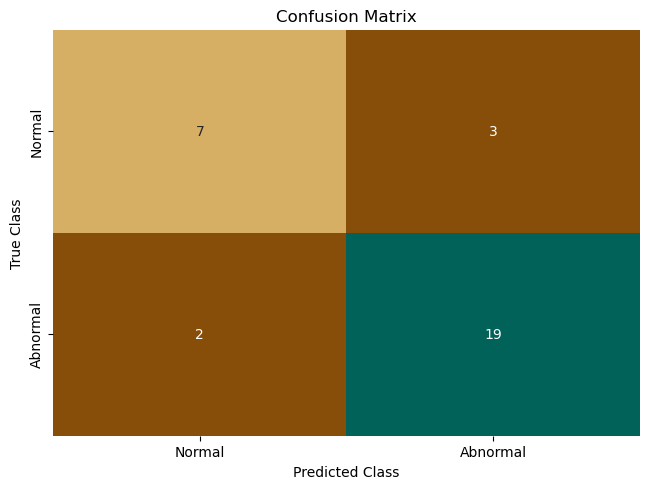

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

## Step: 2 Calculating performance statistics

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 7
False Positive (FP): 3
False Negative (FN): 2
True Positive (TP) : 19


In [15]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

Sensitivity or TPR: 90.47619047619048%
There is a 90.47619047619048% chance of detecting patients with an abnormality have an abnormality


In [16]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")


Specificity or TNR: 70.0%
There is a 70.0% chance of detecting normal patients are normal.


## Positive or negative predictive values

In [17]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

Precision: 86.36363636363636%
You have an abnormality, and the probablity that is correct is 86.36363636363636%


In [18]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 77.77777777777779%
You don't have an abnormality, but there is a 77.77777777777779% chance that is incorrect


## False positive rate

In [19]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 30.0%
There is a 30.0% chance that this positive result is incorrect.


## False negative rate

In [20]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 9.523809523809524%
There is a 9.523809523809524% chance that this negative result is incorrect.


## False discovery rate

In [21]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 13.636363636363635%
You have an abnormality, but there is a 13.636363636363635% chance this is incorrect.


## Overall accuracy

In [22]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 83.87096774193549%


In [23]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 90.47619047619048%
Specificity or TNR: 70.0%
Precision: 86.36363636363636%
Negative Predictive Value: 77.77777777777779%
False Positive Rate: 30.0%
False Negative Rate: 9.523809523809524%
False Discovery Rate: 13.636363636363635%
Accuracy: 83.87096774193549%


**Challenge task-1:** Record the previous values, then go back to step 1 and change the value used for the threshold. Values you should try are *.25* and *.75*. 

Did those threshold values make a difference?

In [24]:
def evaluate_model_with_threshold(test_labels, predicted_probabilities, threshold=0.5):
    target_predicted_binary = (predicted_probabilities[:, 1] >= threshold).astype(int)
    
    # Calculate the confusion matrix and derive TN, FP, FN, TP
    matrix = confusion_matrix(test_labels, target_predicted_binary)
    TN, FP, FN, TP = matrix.ravel()

    # Calculating metrics
    Sensitivity = TP / (TP+FN) * 100
    Specificity = TN / (TN+FP) * 100
    Precision = TP / (TP+FP) * 100
    NPV = TN / (TN+FN) * 100
    FPR = FP / (FP+TN) * 100
    FNR = FN / (TP+FN) * 100
    FDR = FP / (TP+FP) * 100
    ACC = (TP+TN) / (TP+FP+FN+TN) * 100
    
    print(f"Metrics with threshold = {threshold}:")
    print(f"Sensitivity or TPR: {Sensitivity:.2f}%")
    print(f"Specificity or TNR: {Specificity:.2f}%")
    print(f"Precision: {Precision:.2f}%")
    print(f"Negative Predictive Value: {NPV:.2f}%")
    print(f"False Positive Rate: {FPR:.2f}%")
    print(f"False Negative Rate: {FNR:.2f}%")
    print(f"False Discovery Rate: {FDR:.2f}%")
    print(f"Accuracy: {ACC:.2f}%")
    print("------------------------------------------------------\n")

# Evaluate model with different thresholds
evaluate_model_with_threshold(test_labels, predicted_probabilities, threshold=0.25)
evaluate_model_with_threshold(test_labels, predicted_probabilities, threshold=0.75)


Metrics with threshold = 0.25:
Sensitivity or TPR: 90.48%
Specificity or TNR: 70.00%
Precision: 86.36%
Negative Predictive Value: 77.78%
False Positive Rate: 30.00%
False Negative Rate: 9.52%
False Discovery Rate: 13.64%
Accuracy: 83.87%
------------------------------------------------------

Metrics with threshold = 0.75:
Sensitivity or TPR: 80.95%
Specificity or TNR: 80.00%
Precision: 89.47%
Negative Predictive Value: 66.67%
False Positive Rate: 20.00%
False Negative Rate: 19.05%
False Discovery Rate: 10.53%
Accuracy: 80.65%
------------------------------------------------------



## Step: 3 Calculating the AUC-ROC Curve

In [28]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted) )

Validation AUC 0.8761904761904762


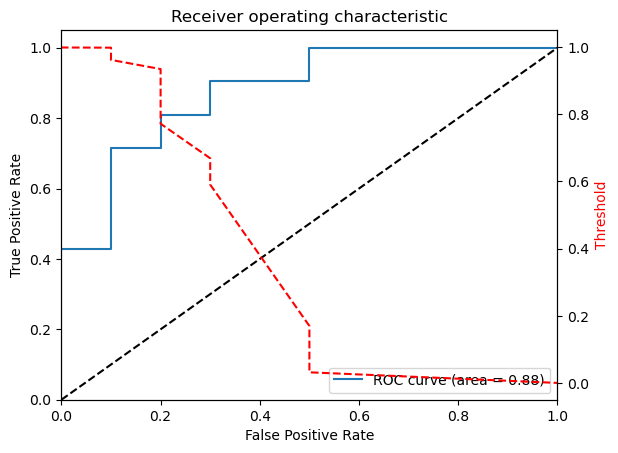

In [29]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming test_labels and target_predicted are defined

fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
ax2.set_ylabel('Threshold', color='r')
ax2.set_xlim([fpr[0], fpr[-1]])

plt.show()

**Challenge task-2:** Update the previous code to use *target_predicted_binary* instead of *target_predicted*. How does that change the graph? Which is the most useful?

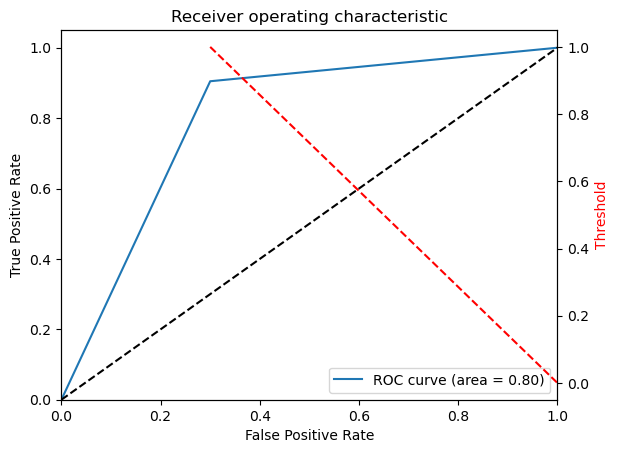

In [30]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming test_labels and target_predicted_binary are defined

fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
ax2.set_ylabel('Threshold', color='r')
ax2.set_xlim([fpr[0], fpr[-1]])

plt.show()